# Titanic Challenge


## Intro



First we must import all the appropriate packages.

In [1]:
# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Accuracy
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_roc_curve

# Data processing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

# Managing data and numbers
import pandas as pd
import numpy as np

# Graphs
import matplotlib.pyplot as plt 
import seaborn as sns

Next, we will insert the data into pandas dataframes. The training data will be used to train each model and the testing data will be used to test the model's accuracy.

In [2]:
# Insert training and test data
train_df = pd.read_csv("train.csv", index_col="PassengerId", skipinitialspace=True)
test_df = pd.read_csv("yu/testdata_with_groundTruth.csv", index_col="PassengerId", skipinitialspace=True)

Let's check the data types of the data. We also check how many null values the training data holds.

In [3]:
# Check nulls and data types
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


There are 177 null values in the Age column, 687 null values in the Cabin column and 2 null values in the Embarked column. All the other columns have all 891 values and no null values. There are 5 object columns which will have to be changed to numerical data so it can be understood by the models. Floats and ints can be used normally.

## Assessing the Current Features
### Pclass

Pclass represents the ticket class. 1 being 1st class, 2 being 2nd class and 3 being 3rd class. This can represent economic status.

           Total  Not Survived  Survived  Survived %
1st Class  216.0          80.0     136.0    0.629630
2nd Class  184.0          97.0      87.0    0.472826
3rd Class  491.0         372.0     119.0    0.242363


<AxesSubplot:xlabel='Survived', ylabel='count'>

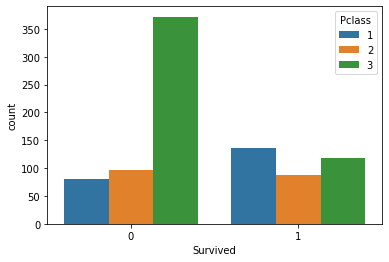

In [4]:
pclass_data = [[], [], [], []]

for i in [1, 2, 3]:
    total = (train_df.Pclass == i).sum()
    pclass_data[0].append(total)
    
    surv = train_df.query(f'Pclass == {i} and Survived == 1')['Pclass'].count()
    pclass_data[1].append(total-surv)
    pclass_data[2].append(surv)
    pclass_data[3].append(1-(total-surv)/total)

pclasses = pd.DataFrame(pclass_data, columns=['1st Class', '2nd Class', '3rd Class'], 
                   index=['Total', 'Not Survived', 'Survived', 'Survived %']).transpose()
print(pclasses)

sns.countplot(data=train_df, hue="Pclass", x="Survived")

There are much more 3rd class passengers than any others. 491 of the 891 passengers being in 3rd class, this is 55% of all passengers. The number of passengers being in 2nd class and 1st class is quite close with 184 and 216 passengers respectively.

The above data shows that the higher the class your ticket is, the more likely you are to survive. 63% of 1st class passengers survived even though 1st class passengers account for 24% of the total passengers. 47% of 2nd class passengers survived and 24% of 3rd class passengers survived.

### Name

A passengers name would not have an impact on whether they survived or not. However, a passenger's title may show differently. We can extract the title from the name. Using one hot encoding is useful because the result will be binary instead of ordinal when using integer encoding. However, a lot more columns will have to be made for this dataset.

#### Creating New Feature: Title

In [7]:
# Extract the title from the name based on the pattern of the name values.
def get_title(name):
    if '.' in name:
        return name.split(',')[1].split('.')[0].strip()
    else:
        # No title
        return 'Unknown'

              Total  Not Survived  Survived  Survived %
Mr            517.0         436.0      81.0    0.156673
Mrs           125.0          26.0      99.0    0.792000
Miss          182.0          55.0     127.0    0.697802
Master         40.0          17.0      23.0    0.575000
Don             1.0           1.0       0.0    0.000000
Rev             6.0           6.0       0.0    0.000000
Dr              7.0           4.0       3.0    0.428571
Mme             1.0           0.0       1.0    1.000000
Ms              1.0           0.0       1.0    1.000000
Major           2.0           1.0       1.0    0.500000
Lady            1.0           0.0       1.0    1.000000
Sir             1.0           0.0       1.0    1.000000
Mlle            2.0           0.0       2.0    1.000000
Col             2.0           1.0       1.0    0.500000
Capt            1.0           1.0       0.0    0.000000
the Countess    1.0           0.0       1.0    1.000000
Jonkheer        1.0           1.0       0.0    0

<AxesSubplot:xlabel='Survived', ylabel='count'>

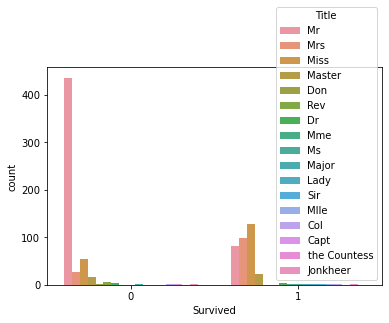

In [8]:
# Create a new column for title
train_df['Title'] = train_df['Name'].map(lambda x: get_title(x))

titles_data = [[], [], [], []]

titles = train_df.Title.unique()
for title in titles:
    total = (train_df.Title == title).sum()
    titles_data[0].append(total)
    
    surv = train_df.query(f'Title == "{title}" and Survived == 1')['Title'].count()
    titles_data[1].append(total-surv)
    titles_data[2].append(surv)
    titles_data[3].append(1-(total-surv)/total)

# Put the titles and their data in a dataframe.
titles_pd = pd.DataFrame(titles_data, columns=titles, 
                   index=['Total', 'Not Survived', 'Survived', 'Survived %']).transpose()

# Show the titles data
print(titles_pd)

sns.countplot(data=train_df, hue="Title", x="Survived")

Titles such as Capt, Col and Jonkheer are rarities as there is only a couple of instances. This data does not tell us much, there is very unequal distribution of the title with Mr, Mrs, Miss and Master being the majority of the titles at 88% of total passengers. All the other titles did not have any values above 7.

Passengers with the title Mr had a low survival rate of 16% whereas Mrs had a survival rate of 79% and Miss has a survival rate of 70%. This shows women, especially married women, would be more likely to survive than men. The title master is used for children and had a survival rate of 58%. Below is the new dataset with the one hot encoding of titles used along with the name removed.

In [9]:
# Create one hot encoding values and columns
titles = pd.get_dummies(train_df.Title)

#Join the one hot encoding title columns to current training dataframe
train_df = train_df.join(titles)

# Drop Name column
train_df = train_df.drop("Name", axis=1)

# Drop Title column
train_df = train_df.drop("Title", axis=1)

# Show new training dataframe
train_df

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,...,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,the Countess
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,...,0,0,0,0,1,0,0,0,0,0
2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,...,0,0,0,0,0,1,0,0,0,0
3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,...,0,1,0,0,0,0,0,0,0,0
4,1,1,female,35.0,1,0,113803,53.1000,C123,S,...,0,0,0,0,0,1,0,0,0,0
5,0,3,male,35.0,0,0,373450,8.0500,NaN,S,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,male,27.0,0,0,211536,13.0000,NaN,S,...,0,0,0,0,0,0,0,1,0,0
888,1,1,female,19.0,0,0,112053,30.0000,B42,S,...,0,1,0,0,0,0,0,0,0,0
889,0,3,female,NaN,1,2,W./C. 6607,23.4500,NaN,S,...,0,1,0,0,0,0,0,0,0,0


### Sex

The Sex column has values of male and female. One hot encoding is not needed for the Sex column as there is only two possible values. The values can just be mapped to 1 or 0 like any individual one hot encoding column.

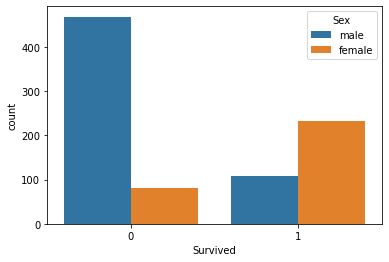

In [10]:
sns.countplot(data=train_df, hue="Sex", x="Survived")

# Map Sex values to numerical values
train_df = train_df.replace({'Sex': {'male': 1, 'female': 0}})

In [11]:
sex_data = [[], [], [], []]

for i in [0, 1]:
    total = (train_df.Sex == i).sum()
    sex_data[0].append(total)
    
    surv = train_df.query(f'Sex == {i} and Survived == 1')['Sex'].count()
    sex_data[1].append(total-surv)
    sex_data[2].append(surv)
    sex_data[3].append(1-(total-surv)/total)
    
sex_pd = pd.DataFrame(sex_data, columns=['Female', 'Male'], 
                   index=['Total', 'Not Survived', 'Survived', 'Survived %']).transpose()
print(sex_pd)

        Total  Not Survived  Survived  Survived %
Female  314.0          81.0     233.0    0.742038
Male    577.0         468.0     109.0    0.188908


There were 577 males aboard accounting for 65% of the passengers whereas there were 314 females. However, 19% of males survived whereas 74% of females survived. This could be due to women and children being given priority to lifeboats. This also follows on from data from title where people with the title of Mr are much more likely to not have survived.

### Age

If age is a fractional then age is less than 1. If the age is estimated, is it in the form of xx.5 Estimation means that the data may not be as concrete as originally thought.

In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 27 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Survived      891 non-null    int64  
 1   Pclass        891 non-null    int64  
 2   Sex           891 non-null    int64  
 3   Age           714 non-null    float64
 4   SibSp         891 non-null    int64  
 5   Parch         891 non-null    int64  
 6   Ticket        891 non-null    object 
 7   Fare          891 non-null    float64
 8   Cabin         204 non-null    object 
 9   Embarked      889 non-null    object 
 10  Capt          891 non-null    uint8  
 11  Col           891 non-null    uint8  
 12  Don           891 non-null    uint8  
 13  Dr            891 non-null    uint8  
 14  Jonkheer      891 non-null    uint8  
 15  Lady          891 non-null    uint8  
 16  Major         891 non-null    uint8  
 17  Master        891 non-null    uint8  
 18  Miss          891 non-null    

As shown, there are 714 Age values of the total of 891 rows. This means Age has 177 null values. 177 values of the total 891 is 19.87%. With a column like age, the mean age could be calculated. This is estimating and could affect the data in a bad way, but so could removing almost 20% of the dataset if the rows with null Ages are removed. 

I will fill the null Age values with the mean age across the dataframe.

Models could be created to estimate the age of a single person more effectively. For example, title and other columns could be taken into account when estimating the age. If the title is Master then the age must be low.

In [13]:
# Fill the null age values with the mean age
train_df['Age'] = train_df['Age'].fillna(train_df['Age'].mean())

<AxesSubplot:xlabel='Age', ylabel='count'>

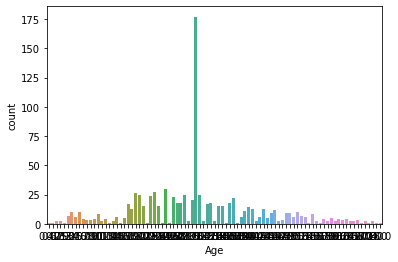

In [14]:
sns.countplot(data=train_df, x="Age")

From the simple graph we can make displaying every age value and its count, it can be a bit complicated and not show us that much. We can see that the majority of people were middle aged.

To improve this, we can use age groups. This may remove some precision but will let us evaluate more efficiently.

In [15]:
max_age = train_df.Age.max()
print(f'Max age: {max_age}')

# Oldest person is 80
# Split ages into groups
ages = [[0, 10], [10, 20], [20, 30], [30, 40], [40, 50], [50, 60], [60, 70], [70, 80]]

age_data = [[], [], [], []]

for i in ages:
    total = train_df.query(f'Age > {i[0]} and Age <= {i[1]}')['Age'].count()
    age_data[0].append(total)
    
    surv = train_df.query(f'Age > {i[0]} and Age <= {i[1]} and Survived == 1')['Age'].count()
    age_data[1].append(total-surv)
    age_data[2].append(surv)
    age_data[3].append(1-(total-surv)/total)


# Change age data to a pandas dataframe.
age_pd = pd.DataFrame(age_data, columns=[f'{a[0]}-{a[1]}' for a in ages], 
                   index=['Total', 'Not Survived', 'Survived', 'Survived %']).transpose()
# Printe age data
print(age_pd)

Max age: 80.0
       Total  Not Survived  Survived  Survived %
0-10    64.0          26.0      38.0    0.593750
10-20  115.0          71.0      44.0    0.382609
20-30  407.0         271.0     136.0    0.334152
30-40  155.0          86.0      69.0    0.445161
40-50   86.0          53.0      33.0    0.383721
50-60   42.0          25.0      17.0    0.404762
60-70   17.0          13.0       4.0    0.235294
70-80    5.0           4.0       1.0    0.200000


The max age is 80 so this is the end of the final age group we use. The majority of the passengers are between 10 and 40 years old, accounting for 56% of total passengers.

The two oldest groups had the worst survival rates of 24% for 60-70 year olds and 20% for 70-80 year olds. This could be because of the cold and extreme conditions.

Passengers aged between 0 and 10 had the best survival rates of 59%. Following this was 30 to 40 with 45% and 50 to 60 with 40%. The only visible pattern is that passengers above 60 had a much lower survival rate even though women, children and elderly people would have been given lifeboats first.

<AxesSubplot:xlabel='Ages', ylabel='Quantity'>

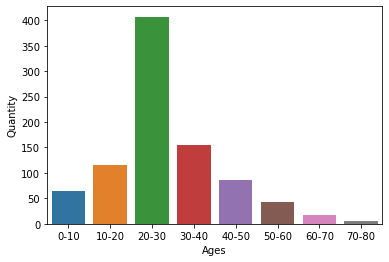

In [16]:
age_ranges = {'Ages':  [f'{a[0]}-{a[1]}' for a in ages],
            'Quantity': age_data[0]}

age_ranges_df = pd.DataFrame (age_ranges, columns = ['Ages','Quantity'])

sns.barplot(data=age_ranges_df, x='Ages', y='Quantity')

This graph allows us to see the better the majority of ages and that there were not many passengers aged above 50.

<AxesSubplot:xlabel='Age', ylabel='Count'>

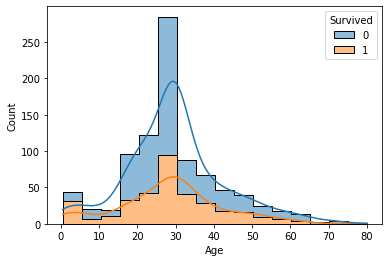

In [17]:
sns.histplot(data = train_df, x="Age", hue = "Survived", multiple = "stack", element = "step", kde = True, bins = 16)

This graph can give us better insight into the age ranges and the survival rate of each age range. As shown, there are a lot of passengers that did not survive between 15 and 40 years old even though these age ranges hold the majority of passengers.

### SibSp

SibSp represents the number of siblings and spouses a passenger has on board the titanic. Mistresses and fiancés have been ignored meaning that the SibSp number could actually be higher than what is recorded, like for passengers who only travelled with a mistress.

   Total  Not Survived  Survived  Survived %
0  608.0         398.0     210.0    0.345395
1  209.0          97.0     112.0    0.535885
2   28.0          15.0      13.0    0.464286
3   16.0          12.0       4.0    0.250000
4   18.0          15.0       3.0    0.166667
5    5.0           5.0       0.0    0.000000
8    7.0           7.0       0.0    0.000000


<AxesSubplot:xlabel='Survived', ylabel='count'>

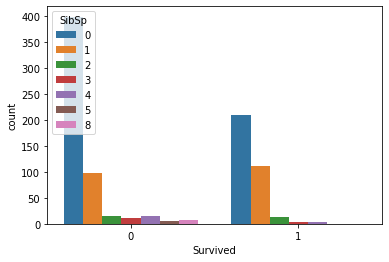

In [18]:
# Get unique values
sibsps = test_df.SibSp.unique()
# Sort unique values
sibsps = np.sort(sibsps)

sibsp_data = [[], [], [], []]

for i in sibsps:
    total = train_df.query(f'SibSp == {i}')['SibSp'].count()
    sibsp_data[0].append(total)
    
    surv = train_df.query(f'SibSp == {i} and Survived == 1')['SibSp'].count()
    sibsp_data[1].append(total-surv)
    sibsp_data[2].append(surv)
    sibsp_data[3].append(1-(total-surv)/total)

# Convert SibSp data to dataframe
sibsp_data = pd.DataFrame(sibsp_data, columns=sibsps, 
                   index=['Total', 'Not Survived', 'Survived', 'Survived %']).transpose()
# Print dataframe
print(sibsp_data)
    
sns.countplot(data=train_df, hue="SibSp", x="Survived")

The SibSp value is not very equally distributed across the passengers. The most common value of SibSp is 0 with 608 passengers accounting for 68% of total passengers. This is followed by the SibSp value of 1 with 209 passengers accounting for 23% of passengers. This means that all passengers with 2 or more SibSp accounts for 9% of the training data.

A passenger with more than 1 sibling and spouse on the Titanic is rare and all passengers with 5 or more siblings and spouse on board do not survive. The greatest survival rate is a SibSp value of 1 with 54% followed by 2 with 46%.

<AxesSubplot:xlabel='SibSp', ylabel='Count'>

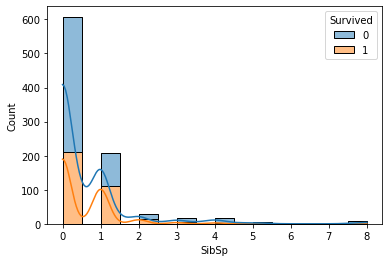

In [19]:
sns.histplot(data = train_df, x="SibSp", hue = "Survived", multiple = "stack", element = "step", kde = True, bins = 16)

This graph helps to show how unequally distributed the SibSp values are and even though 0 was the most common value, it  did not have the greatest survival rate.

### Parch

Parch is the number of parents and children a passenger has on board the Titanic. If children had travelled with a nanny, their parch value is 0.

   Total  Not Survived  Survived  Survived %
0  678.0         445.0     233.0    0.343658
1  118.0          53.0      65.0    0.550847
2   80.0          40.0      40.0    0.500000
3    5.0           2.0       3.0    0.600000
4    4.0           4.0       0.0    0.000000
5    5.0           4.0       1.0    0.200000
6    1.0           1.0       0.0    0.000000
9    0.0           0.0       0.0         NaN


C:\Users\jknot\Anaconda3\envs\ML\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in long_scalars
  from ipykernel import kernelapp as app


<AxesSubplot:xlabel='Survived', ylabel='count'>

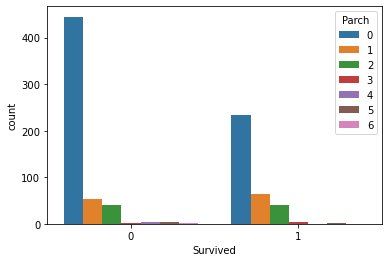

In [20]:
# Get unique values
parchs = test_df.Parch.unique()
# Sort unique values
parchs = np.sort(parchs)

parch_data = [[], [], [], []]

for i in parchs:
    total = train_df.query(f'Parch == {i}')['Parch'].count()
    parch_data[0].append(total)
    
    surv = train_df.query(f'Parch == {i} and Survived == 1')['Parch'].count()
    parch_data[1].append(total-surv)
    parch_data[2].append(surv)
    parch_data[3].append(1-(total-surv)/total)
    
# Convert parch data to a dataframe
parch_data = pd.DataFrame(parch_data, columns=parchs, 
                   index=['Total', 'Not Survived', 'Survived', 'Survived %']).transpose()
# Print data frame
print(parch_data)

sns.countplot(data=train_df, hue="Parch", x="Survived")

Like SibSp, Parch is not very varied. The number of passengers with more than 2 parents and children is very small at just 10 passengers out of the 891 making that only 1% of passengers. The Parch value with the greatest survival rate is 3 with a 60% surival rate. However, the Parch value of 3 has only 5 passengers being 0.5% of the total passengers in the training dataset.

Out of the Parch values below 3, which have 80 passengers or more, the greatest survival rate is a Parch value of 1 with 55% survival rate. Following this, a Parch value of 2 has a survival rate of 50%. The Parch value of 0 has the greatest amount of passengers but a low survival rate of 34%.

<AxesSubplot:xlabel='Parch', ylabel='Count'>

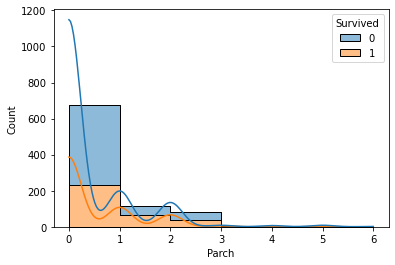

In [21]:
sns.histplot(data = train_df, x="Parch", hue = "Survived", multiple = "stack", element = "step", kde = True, bins = 6)

Just like SibSp, the Parch of 0 is the most common but has quite a poor survival rate compared to the other values.

#### Creating New Feature: Family

The new Family feature will hold the number of people who are in the group of that passenger. This will be calculated by adding the number of siblings, spouses, parents and children

    Total  Not Survived  Survived  Survived %
0   537.0         374.0     163.0    0.303538
1   161.0          72.0      89.0    0.552795
2   102.0          43.0      59.0    0.578431
3    29.0           8.0      21.0    0.724138
4    15.0          12.0       3.0    0.200000
5    22.0          19.0       3.0    0.136364
6    12.0           8.0       4.0    0.333333
7     6.0           6.0       0.0    0.000000
10    7.0           7.0       0.0    0.000000


<AxesSubplot:xlabel='Survived', ylabel='count'>

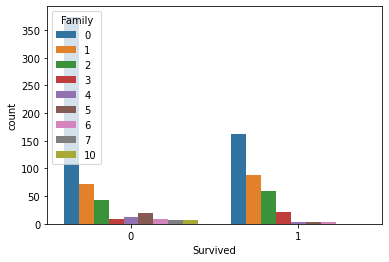

In [22]:
# Make new column
train_df['Family'] = train_df['SibSp'] + train_df['Parch']
# Get unique values
family = train_df['Family'].unique()
# Sort unique values
family = np.sort(family)

family_data = [[], [], [], []]

for i in family:
    total = train_df.query(f'Family == {i}')['Family'].count()
    family_data[0].append(total)
    
    surv = train_df.query(f'Family == {i} and Survived == 1')['Family'].count()
    family_data[1].append(total-surv)
    family_data[2].append(surv)
    family_data[3].append(1-(total-surv)/total)
    
# Put family data into dataframe
family_data = pd.DataFrame(family_data, columns=family, 
                   index=['Total', 'Not Survived', 'Survived', 'Survived %']).transpose()
# Print family dataframe
print(family_data)
    
sns.countplot(data=train_df, hue="Family", x="Survived")

If we combine the SibSp and Parch values to make a new value of Family for each passenger, representing the total number of family members they were with on the Titanic, this shows very small number of occurances of values above 2. 

We can see the majority of passengers had 0 family members and out of the values which had more than 100 occurances, this had the lowest survival rate of 30%. Passengers with 1 family member and 2 family members had similar survival rates being 55% and 58% respectively.

<AxesSubplot:xlabel='Family', ylabel='Count'>

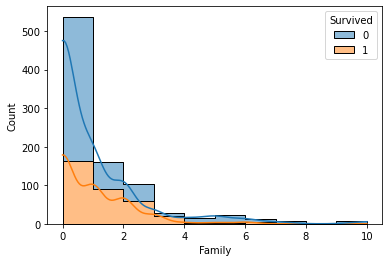

In [23]:
sns.histplot(data = train_df, x="Family", hue = "Survived", multiple = "stack", element = "step", kde = True, bins = 10)

Again, we can see here that the majority of passengers had 0 family members and that if a passenger had 0 family members then they would have a low chance of surviving.

### Ticket

Ticket may give us information, such as if multiple tickets were bought at once or the same ticket (number) were used by multiple people. However, to convert this to meaningful numerical data would be very difficult. To one hot encode this value, another 363 columns would need to be created as this is the number of unique ticket values. This column will therefore be removed.

In [24]:
print(f'Unique ticket values: {len(test_df.Ticket.unique())}')
train_df = train_df.drop('Ticket', axis = 1)

Unique ticket values: 363


### Fare

Fare simply shows us how much passengers paid for their tickets.

In [25]:
# Remove NaN values with the Fare mean
test_df['Fare'] = test_df['Fare'].fillna(test_df['Fare'].mean())

# Max value is 512
max_fare = train_df.Fare.max()
print(f'Max Fare: {max_fare}\n')

fares = [[0, 20], [20, 40], [40, 60], [60, 80], [80, 100], [100, 200], [200, 600]]
fare_data = [[], [], [], []]

for i in fares:
    total = train_df.query(f'Fare > {i[0]} and Fare <= {i[1]}')['Fare'].count()
    fare_data[0].append(total)
    
    surv = train_df.query(f'Fare > {i[0]} and Fare <= {i[1]} and Survived == 1')['Fare'].count()
    fare_data[1].append(total-surv)
    fare_data[2].append(surv)
    fare_data[3].append(1-(total-surv)/total)

# Convert fare data to dataframe
fare_pd = pd.DataFrame(fare_data, columns=[f'{f[0]}-{f[1]}' for f in fares], 
                   index=['Total', 'Not Survived', 'Survived', 'Survived %']).transpose()
# Print fare data
print(fare_pd)

Max Fare: 512.3292

         Total  Not Survived  Survived  Survived %
0-20     500.0         358.0     142.0    0.284000
20-40    200.0         114.0      86.0    0.430000
40-60     54.0          23.0      31.0    0.574074
60-80     48.0          23.0      25.0    0.520833
80-100    21.0           3.0      18.0    0.857143
100-200   33.0           8.0      25.0    0.757576
200-600   20.0           6.0      14.0    0.700000


500 passengers paid between 0-20 which accounts for 56% of the total passengers. 200 passengers paid between 20-40 which is 22% of total passengers. Together, 78% of passengers paid between 0-40 and these passengers had the worst survival rate. The best survival rate were passengers who paid between 80-100 with a survival rate of 86%. In fact, any passenger who paid more than 80 had a survival rate of at least 70%. There is definitely a pattern that if you paid more for your ticket, you were more likely to survive.

<AxesSubplot:xlabel='Fare', ylabel='count'>

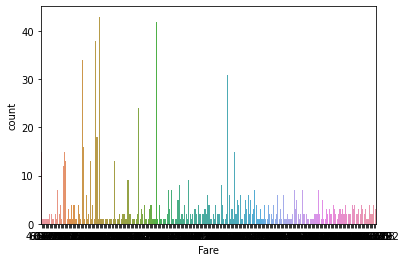

In [26]:
sns.countplot(data=train_df, x="Fare")

The only things this graph can show is that there is a lot of unique values of fares paid and that the distribution is very unequal.

<AxesSubplot:xlabel='Fares', ylabel='Quantity'>

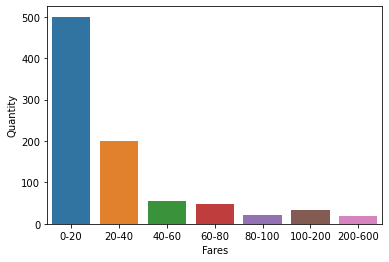

In [27]:
fare_ranges = {'Fares':  [f'{f[0]}-{f[1]}' for f in fares],
            'Quantity': fare_data[0]}

fare_ranges_df = pd.DataFrame (fare_ranges, columns = ['Fares','Quantity'])

sns.barplot(data=fare_ranges_df, x='Fares', y='Quantity')

From the graph, the majority of passengers paid between 0 and 40. Even though the number of people paying above 40 is much less than those paying less, there is a pattern showing the more you pay for your ticket the more likely you are to survive. Passengers paying below 20 have a survival rate of 28% and passengers paying between 20 and 40 have a survival rate of 43%. However, all passengers paying above 40 have a survival rate of greater than 50%.

<AxesSubplot:xlabel='Fare', ylabel='Count'>

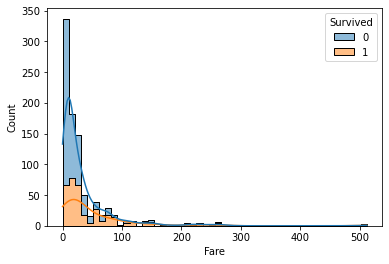

In [28]:
sns.histplot(data = train_df, x="Fare", hue = "Survived", multiple = "stack", element = "step", kde = True, bins = 50)

This graph shows us how unequal the distribution is and how little passengers paid for very expensive tickets compared to the number of passengers who paid for much cheaper tickets. It also shows that the passengers who had very cheap tickets had quite a low survival rate.

### Cabin

The cabin column has 687 null values which is around 77% of the total dataset. It would not be worth trying to replace the null values because of the data structure and there are too many null values. Otherwise, this data could have told us information such as what floor each passenger was on. his column will be removed.

In [29]:
print(f'Cabin null values: {train_df.Cabin.isna().sum()}')
train_df = train_df.drop("Cabin", axis = 1)

Cabin null values: 687


### Embarked

Embarked tells us where the port of embarkation for the passenger.

In [30]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Survived      891 non-null    int64  
 1   Pclass        891 non-null    int64  
 2   Sex           891 non-null    int64  
 3   Age           891 non-null    float64
 4   SibSp         891 non-null    int64  
 5   Parch         891 non-null    int64  
 6   Fare          891 non-null    float64
 7   Embarked      889 non-null    object 
 8   Capt          891 non-null    uint8  
 9   Col           891 non-null    uint8  
 10  Don           891 non-null    uint8  
 11  Dr            891 non-null    uint8  
 12  Jonkheer      891 non-null    uint8  
 13  Lady          891 non-null    uint8  
 14  Major         891 non-null    uint8  
 15  Master        891 non-null    uint8  
 16  Miss          891 non-null    uint8  
 17  Mlle          891 non-null    uint8  
 18  Mme           891 non-null    

As you can see from the training dataframe info, there are two null values in the Embarked column.

In [31]:
emb_data = [[], [], [], []]

ports = train_df['Embarked'].unique()

for i in ports:
    total = (train_df.Embarked == i).sum()
    emb_data[0].append(total)
        
    surv = train_df.query(f'Embarked == "{i}" and Survived == 1')['Embarked'].count()
    emb_data[1].append(total-surv)
    emb_data[2].append(surv)
    emb_data[3].append(1-(total-surv)/total)
    
emb_data = pd.DataFrame(emb_data, columns=ports, 
                   index=['Total', 'Not Survived', 'Survived', 'Survived %']).transpose()
print(emb_data)

     Total  Not Survived  Survived  Survived %
S    644.0         427.0     217.0    0.336957
C    168.0          75.0      93.0    0.553571
Q     77.0          47.0      30.0    0.389610
NaN    0.0           0.0       0.0         NaN


C:\Users\jknot\Anaconda3\envs\ML\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in longlong_scalars
  if sys.path[0] == '':


<AxesSubplot:xlabel='Survived', ylabel='count'>

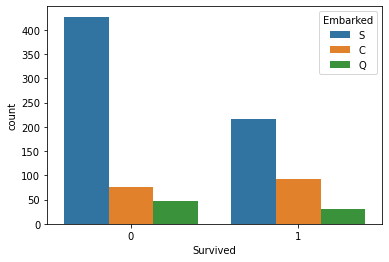

In [32]:
sns.countplot(data=train_df, hue="Embarked", x="Survived")

The majority of passengers embarked from Southampton, this would be because the Titanic started its journey from Southampton. Passengers who embarked form Southampton made up 66% of all passengers but had the worst survival rate which was 34%.

Passengers from Cherbourg had the best survival rate of 55%.

In [33]:
# Get one hot encoding columns for embarked
emarked = pd.get_dummies(train_df.Embarked)

# Join the one hot encoded embarked columns to the training dataframe
train_df = train_df.join(emarked)

# Drop the Embarked column which held non-numerical values
train_df = train_df.drop("Embarked", axis=1)

The Embarked column has now been replaced with three columns which are the result of one hot encoding the Embarked column. Columns C, Q and S have been added and will have the value of 1 if a passenger has embarked from Cherbourg, Queenstown or Southampton respectively.

In [34]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 28 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Survived      891 non-null    int64  
 1   Pclass        891 non-null    int64  
 2   Sex           891 non-null    int64  
 3   Age           891 non-null    float64
 4   SibSp         891 non-null    int64  
 5   Parch         891 non-null    int64  
 6   Fare          891 non-null    float64
 7   Capt          891 non-null    uint8  
 8   Col           891 non-null    uint8  
 9   Don           891 non-null    uint8  
 10  Dr            891 non-null    uint8  
 11  Jonkheer      891 non-null    uint8  
 12  Lady          891 non-null    uint8  
 13  Major         891 non-null    uint8  
 14  Master        891 non-null    uint8  
 15  Miss          891 non-null    uint8  
 16  Mlle          891 non-null    uint8  
 17  Mme           891 non-null    uint8  
 18  Mr            891 non-null    

## Null Values

In [35]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 28 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Survived      891 non-null    int64  
 1   Pclass        891 non-null    int64  
 2   Sex           891 non-null    int64  
 3   Age           891 non-null    float64
 4   SibSp         891 non-null    int64  
 5   Parch         891 non-null    int64  
 6   Fare          891 non-null    float64
 7   Capt          891 non-null    uint8  
 8   Col           891 non-null    uint8  
 9   Don           891 non-null    uint8  
 10  Dr            891 non-null    uint8  
 11  Jonkheer      891 non-null    uint8  
 12  Lady          891 non-null    uint8  
 13  Major         891 non-null    uint8  
 14  Master        891 non-null    uint8  
 15  Miss          891 non-null    uint8  
 16  Mlle          891 non-null    uint8  
 17  Mme           891 non-null    uint8  
 18  Mr            891 non-null    

As you can see, now no column has null values and all values are numerical.

## Preparing Test Data

The test data must be prepared the same as the training data.

In [36]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  418 non-null    int64  
 1   Pclass    418 non-null    int64  
 2   Name      418 non-null    object 
 3   Sex       418 non-null    object 
 4   Age       332 non-null    float64
 5   SibSp     418 non-null    int64  
 6   Parch     418 non-null    int64  
 7   Ticket    418 non-null    object 
 8   Fare      418 non-null    float64
 9   Cabin     91 non-null     object 
 10  Embarked  418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 39.2+ KB


The test dataframe has null values, non-numerical values and is missing 17 columns compared to the training data.

In [37]:
# Convert to numerical values
test_df = test_df.replace({'Sex': {'male': 1, 'female': 0}})

First we can replace the Sex values in the test data for a 1 or a 0.

In [38]:
# Extract titles from the name column
test_df['Title'] = test_df['Name'].map(lambda x: get_title(x))

# One hot encode the titles to a new set of columns
titles = pd.get_dummies(test_df.Title)

# Join the one hot encoded title columns to the test data
test_df = test_df.join(titles)

Next we have one hot encoded the titles from the names in the test data and added all these columns to the test data.

In [39]:
# One hot encode the embarked column
emarked = pd.get_dummies(test_df.Embarked)

# Add the one hot encoded embarked columns
test_df = test_df.join(emarked)

The Embarked column has also been one hot encoded and the columns have been added to the test dataframe.

In [40]:
# Add Family column
test_df['Family'] = test_df['SibSp'] + test_df['Parch']

The family column has been added to the test data to represent the number of family members a passenger was with on the Titanic.

In [41]:
# Drop the cabin column as there are too many null values
test_df = test_df.drop('Cabin', axis = 1)

# Drop name column as we have extracted the titles from the names
test_df = test_df.drop('Name', axis = 1)

# Drop the titles column as we have one hot encoded them
test_df = test_df.drop("Title", axis=1)

# Drop the ticket column as we have dropped it in the training data and it does not give us useful information at this point
test_df = test_df.drop('Ticket', axis = 1)

# Drop the embarked column as we have one hot encoded the embarkation ports
test_df = test_df.drop("Embarked", axis=1)

The same columns that were removed from the training data have also been removed from the test data.

In [42]:
# Remove nulls from the age column with the mean age
test_df['Age'] = test_df['Age'].fillna(test_df['Age'].mean())

The only null values will now be in the age column so these will be filled with the mean age.

It must be noted that the mean age for the test data was calculated only using the test data like the mean age for the training data was calculated only using the training data. It is most probable that these two means will be different. Like before, it should be stated that replacing null values with mean data will have an affect on the outcome but it is the best option at this moment.

In [43]:
# Get all columns from training dataset
train_cols = list(train_df.columns.values)
print(train_cols)

['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Capt', 'Col', 'Don', 'Dr', 'Jonkheer', 'Lady', 'Major', 'Master', 'Miss', 'Mlle', 'Mme', 'Mr', 'Mrs', 'Ms', 'Rev', 'Sir', 'the Countess', 'Family', 'C', 'Q', 'S']


In [44]:
# Get all columns from testing dataset
test_cols = list(test_df.columns.values)
print(test_cols)

['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Col', 'Dona', 'Dr', 'Master', 'Miss', 'Mr', 'Mrs', 'Ms', 'Rev', 'C', 'Q', 'S', 'Family']


After printing all the columns from the training dataset and the testing dataset, we can see that the testing dataset is missing columns. Not only that, there are columns unique to each dataset because of titles only occuring in one dataset or the other.

To fix this, empty columns with all values at 0 can be added to each dataset.

In [45]:
# Add empty one hot encoding columns to training and testing data
for col in train_cols:
    if col not in test_cols:
        test_df[col] = 0
        
for col in test_cols:
    if col not in train_cols:
        train_df[col] = 0

Each of the datasets will be gone through and checked if they have each of the columns in the corresponding datasets. If they do not have the column, a column will be added with values of 0 so that each dataset will have matching columns.

In [47]:
# Sort data frames by column names
train_df = train_df.sort_index(axis = 1)
test_df = test_df.sort_index(axis = 1)

print(train_df.info())
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age           891 non-null    float64
 1   C             891 non-null    uint8  
 2   Capt          891 non-null    uint8  
 3   Col           891 non-null    uint8  
 4   Don           891 non-null    uint8  
 5   Dona          891 non-null    int64  
 6   Dr            891 non-null    uint8  
 7   Family        891 non-null    int64  
 8   Fare          891 non-null    float64
 9   Jonkheer      891 non-null    uint8  
 10  Lady          891 non-null    uint8  
 11  Major         891 non-null    uint8  
 12  Master        891 non-null    uint8  
 13  Miss          891 non-null    uint8  
 14  Mlle          891 non-null    uint8  
 15  Mme           891 non-null    uint8  
 16  Mr            891 non-null    uint8  
 17  Mrs           891 non-null    uint8  
 18  Ms            891 non-null    

As we can see, both the training and testing datasets now have no nulls and consistent columns.

For some ML models, it is wise to scale the data. Unscaled data can affect performance of models such as KNN, where varying magnitudes of data can decrease performance.

In [48]:
test_surv = test_df['Survived']
test_df = test_df.drop('Survived', axis=1)

train_surv = train_df['Survived']
train_df = train_df.drop('Survived', axis=1)

In [49]:
scaler = StandardScaler()
train_sc = scaler.fit_transform(train_df)
test_sc = scaler.transform(test_df)

## ML Models

The models I will be implementing are:
- Random Forest
- Logistic Regression
- K Nearest Neighbours
- Support Vector Machine





### Random Forest

Note: as the Random Forest Classifer has random elements to it, every time it is run the result may change slightly. The other models have consistent results.

In [50]:
# Initialise the model
rfc = RandomForestClassifier()

# Train the model on the training data and the training data survivors
rfc.fit(train_df, train_surv)

# Predict the survivors from the test data
pred = rfc.predict(test_df)

# Get an accuracy score from the test data prediction
rfc_acc = accuracy_score(test_surv, pred)

# Print accuracy
print(rfc_acc)

0.7583732057416268


The RF model gives an accuracy score of 75.84%.

In [51]:
print(confusion_matrix(test_surv, pred))

[[210  50]
 [ 51 107]]


The confusion matrix is pretty good. There are 210 true negatives out of a total of 260 negatives and 107 true positives out of a total of 158 positives.

In [52]:
print(classification_report(test_surv, pred))

              precision    recall  f1-score   support

           0       0.80      0.81      0.81       260
           1       0.68      0.68      0.68       158

    accuracy                           0.76       418
   macro avg       0.74      0.74      0.74       418
weighted avg       0.76      0.76      0.76       418



The confusion matrix gives us more insight into how well the model performs. It shows scores for predicting the negatives and the positives.

Precision shows what percentage of predictions were correct. Recall is what percentage of cases did you catch. The f1-score gives a balance between precision and recall.

The scores for predicting negatives are better throughout than the scores for prediciting positives.

In [53]:
# RF hyperparameters
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

grid_search = GridSearchCV(estimator = RandomForestClassifier(), param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(train_df, train_surv)

print(grid_search.best_params_)

Fitting 3 folds for each of 576 candidates, totalling 1728 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 1728 out of 1728 | elapsed:  4.8min finished


{'bootstrap': False, 'max_depth': 80, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 200}


The best parameters for this model in this scenario are 80 max depth, 2 max features, 3 min samples lead, 10 min samples split, 200 estimators and bootstrap set to false.

In [54]:
# Make a new Random Forest model based on the best parameters found before
rfc = RandomForestClassifier(**grid_search.best_params_)

# Fit the model to the training data
rfc.fit(train_df, train_surv)

# Get a predicition from the test data
pred = rfc.predict(test_df)

# Generate an accuracy from the prediction
rfc_acc = accuracy_score(test_surv, pred)

print(rfc_acc)

0.7799043062200957


The accuracy score with the new parameters is 77.99% which is 2.15% more than the previous score.

In [55]:
print(confusion_matrix(test_surv, pred))
rfc_confusion = confusion_matrix(test_surv, pred)

[[223  37]
 [ 55 103]]


The updated RF has more TN and TP with its updated hyperparameters.

In [56]:
print(classification_report(test_surv, pred))
rfc_classification = classification_report(test_surv, pred, output_dict=True)

              precision    recall  f1-score   support

           0       0.80      0.86      0.83       260
           1       0.74      0.65      0.69       158

    accuracy                           0.78       418
   macro avg       0.77      0.75      0.76       418
weighted avg       0.78      0.78      0.78       418



The scores for predicting positives was a bit lower than the scores for predicting negatives. However, predicting positives with the new RF model has improved for precision and f1-score.

In [57]:
feature_importances = pd.DataFrame({'feature': test_df.columns,'importance': rfc.feature_importances_})
feature_importances = feature_importances.sort_values('importance',ascending=False).set_index('feature')
feature_importances

,importance
feature,
Mr,0.163670
Sex,0.156665
Fare,0.137175
Pclass,0.097089
Mrs,0.082181
Age,0.080477
Miss,0.070664
Family,0.051544
Rev,0.040620


We can see with RF which features had the most importance. As seen, a lot of the rare titles had zero weight on decisions. The most important were Mr, Fare and Sex which means that the gender and how much the passenger's ticket cost was more important for this model to decide if the passenger survived or not.

### Logistic Regression

In [58]:
# Initialise the model
lr = LogisticRegression()

# Fit the model with the training data
lr.fit(train_df, train_surv)

# Get a prediciton for the test data
pred = lr.predict(test_df)

# Get an accuracy score for the predicition
lr_acc = accuracy_score(test_surv, pred)

print(lr_acc)

0.777511961722488


C:\Users\jknot\Anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


There was an accuracy score of 77.75% with the Logistic Regression model. However, accuracy does not show everything.

In [59]:
print(confusion_matrix(test_surv, pred))

[[209  51]
 [ 42 116]]


There are 209 true negatives and 116 true positives. There are 51 false negatives and 42 false positives.

In [60]:
print(classification_report(test_surv, pred))

              precision    recall  f1-score   support

           0       0.83      0.80      0.82       260
           1       0.69      0.73      0.71       158

    accuracy                           0.78       418
   macro avg       0.76      0.77      0.77       418
weighted avg       0.78      0.78      0.78       418



The classification report shows us how the model performed in other metrics. When predicting a positive there is not much accuracy unlike predicting a negative. For example, predicting a negative has a 14% better precision than predicting a positive.

Now we will use different combination of parameters to see which ones are most suitable for this model in this scenario. After this, we can test the model again and see if it improves.

In [61]:
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter':[100, 500, 1000, 5000, 10000],
    'C': [0.01, 0.1, 1, 10, 100]
}

grid_search = GridSearchCV(estimator = LogisticRegression(), param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(train_df, train_surv)

print(grid_search.best_params_)

Fitting 3 folds for each of 375 candidates, totalling 1125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 758 tasks      | elapsed:   12.1s


{'C': 1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}


[Parallel(n_jobs=-1)]: Done 1125 out of 1125 | elapsed:   26.1s finished
C:\Users\jknot\Anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [62]:
# Make a new Logistic Regression model based on the best parameters found before
lr = LogisticRegression(**grid_search.best_params_)

# Fit the model with the training data
lr.fit(train_df, train_surv)

# Predict with the test data
pred = lr.predict(test_df)

# Get an accuracy score with the predicition
lr_acc = accuracy_score(test_surv, pred)

print(lr_acc)

0.777511961722488


C:\Users\jknot\Anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


We get the same accuracy result as previously with a score of 77.75%.

In [63]:
print(confusion_matrix(test_surv, pred))
lr_confusion = confusion_matrix(test_surv, pred)

[[209  51]
 [ 42 116]]


In [64]:
print(classification_report(test_surv, pred))
lr_classification = classification_report(test_surv, pred, output_dict=True)

              precision    recall  f1-score   support

           0       0.83      0.80      0.82       260
           1       0.69      0.73      0.71       158

    accuracy                           0.78       418
   macro avg       0.76      0.77      0.77       418
weighted avg       0.78      0.78      0.78       418



We also get the same confusion matrix and classification reports as before. These will be used later to compare against other models.

### K Nearest Neighbours

In [65]:
# Initialise model
knn = KNeighborsClassifier()

# Fit the model with the training data
knn.fit(train_df, train_surv)

# Make a predicition with the test data
pred = knn.predict(test_df)

# Create an accuracy score with the predicition.
knn_acc = accuracy_score(test_surv, pred)

print(knn_acc)

0.6578947368421053


KNN has produced an accuracy score of 65.79%.

In [66]:
print(confusion_matrix(test_surv, pred))

[[193  67]
 [ 76  82]]


For the KNN confusion matrix, only one value stands out which is the true negative with 193 results. The other results are quite similar, meaning it is a poor model.

In [67]:
print(classification_report(test_surv, pred))

              precision    recall  f1-score   support

           0       0.72      0.74      0.73       260
           1       0.55      0.52      0.53       158

    accuracy                           0.66       418
   macro avg       0.63      0.63      0.63       418
weighted avg       0.65      0.66      0.66       418



The classification report shows how poor this KNN model is at predicting positives with all positive scores below 56%.

To improve the KNN model, we can use scaled data. KNN does not deal with a varying magnitude of data values.

In [68]:
# Scaled data
# Fit the model to the scaled training data
knn.fit(train_sc, train_surv)

# Predict with the scaled test data
pred = knn.predict(test_sc)

# Generate an accuracy score
knn_acc = accuracy_score(test_surv, pred)

print(knn_acc)

0.7631578947368421


With scaled data, KNN has got an accuracy score of 76.32% which is 10.53% greater than the previous score it generated.

In [69]:
print(confusion_matrix(test_surv, pred))

[[205  55]
 [ 44 114]]


The confusion matrix is also much better with a clear improvment for the true positives.

In [70]:
print(classification_report(test_surv, pred))

              precision    recall  f1-score   support

           0       0.82      0.79      0.81       260
           1       0.67      0.72      0.70       158

    accuracy                           0.76       418
   macro avg       0.75      0.75      0.75       418
weighted avg       0.77      0.76      0.76       418



The classification report shows an improvement in prediciting positives. Previously the positive recall had a score of 52% whereas now it has a score of 72%. All scores had improved when using scaled data.

In [71]:
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric':['euclidean', 'manhattan', 'chebyshev', 'minkowski'],
    'leaf_size': [15, 30, 45, 60]
}

grid_search = GridSearchCV(estimator = KNeighborsClassifier(), param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(train_sc, train_surv)

print(grid_search.best_params_)

Fitting 3 folds for each of 160 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s


{'leaf_size': 15, 'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'uniform'}


[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:    2.0s finished


The best parameters found for the KNN in this scenario is to use 7 neighbours, a leaf size of 15, uniform weights and Euclidean metric. The parameters were also tested with the scaled data.

In [72]:
# Make a new KNN model based on the best parameters found before
knn = KNeighborsClassifier(**grid_search.best_params_)

# Fit the model to the scaled data
knn.fit(train_sc, train_surv)

# Get a prediction from the scaled test data
pred = knn.predict(test_sc)

# Generate an accuracy score
knn_acc = accuracy_score(test_surv, pred)

print(knn_acc)

0.7799043062200957


The final accuracy score for KNN is 77.99% which is a massive improvement from its original score of 65.79%.

In [73]:
print(confusion_matrix(test_surv, pred))
knn_confusion = confusion_matrix(test_surv, pred)

[[212  48]
 [ 44 114]]


The confusion matrix improves only with the true negatives from the previous matrix.

In [74]:
print(classification_report(test_surv, pred))
knn_classification = classification_report(test_surv, pred, output_dict=True)

              precision    recall  f1-score   support

           0       0.83      0.82      0.82       260
           1       0.70      0.72      0.71       158

    accuracy                           0.78       418
   macro avg       0.77      0.77      0.77       418
weighted avg       0.78      0.78      0.78       418



Like the confusion matrix, there is not much difference with the confusion report compared to the one before the parameter search.

### Support Vector Machine

In [75]:
# Initialise model
svc = SVC()

# Fit the model to the training data
svc.fit(train_df, train_surv)

# Get a predicition from the testing data
pred = svc.predict(test_df)

# Generate an accuracy score
svc_acc = accuracy_score(test_surv, pred)

print(svc_acc)

0.6674641148325359


With the standard SVC model, an accuracy score of 66.75% is generated. This accuracy score does not seem to bad, but when evaluating the confusion matrix and classification report you can see that this current model is quite poor.

In [76]:
print(confusion_matrix(test_surv, pred))

[[232  28]
 [111  47]]


The results from this confusion matrix are quite poor. There are a lot more false positives than true positives. It is quite good at predicting negative results as there is only 28 false negatives out of 260 total negatives.

In [77]:
print(classification_report(test_surv, pred))

              precision    recall  f1-score   support

           0       0.68      0.89      0.77       260
           1       0.63      0.30      0.40       158

    accuracy                           0.67       418
   macro avg       0.65      0.59      0.59       418
weighted avg       0.66      0.67      0.63       418



The classification report shows how awful this SVC model is at prediciting positive results. A recall score of 30% and f1-score of 40% is quite terrible.

This model will now be fitted with the scaled data.

In [78]:
# Fit model with scaled training data
svc.fit(train_sc, train_surv)

# Get a prediction using the scaled test data
pred = svc.predict(test_sc)

# Get an accuracy score from the prediction
svc_acc = accuracy_score(test_surv, pred)

print(svc_acc)

0.777511961722488


The accuracy score using scaled data is much better than the previous accuracy score of 66.75%. The scaled accuracy score of 77.75% is 11% greater than when non scaled data had been used.

In [79]:
print(confusion_matrix(test_surv, pred))

[[211  49]
 [ 44 114]]


The confusion matrix also has a massive improvement for the positive predictions. Now there are more true positives instead of false positives, unlike before. The number of true negatives has actually decreased using scaled data.

In [80]:
print(classification_report(test_surv, pred))

              precision    recall  f1-score   support

           0       0.83      0.81      0.82       260
           1       0.70      0.72      0.71       158

    accuracy                           0.78       418
   macro avg       0.76      0.77      0.76       418
weighted avg       0.78      0.78      0.78       418



The classification report also shows the dramatic improvement of this model predicting positives as the positive recall score has increase 42% and the positive f1-score has increase 31%.

In [81]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100, 1000],  
    'gamma': [2, 1, 0.1, 0.01, 0.001, 0.0001], 
    'kernel': ['rbf', 'linear', 'sigmoid']
}

grid_search = GridSearchCV(estimator = SVC(), param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(train_sc, train_surv)

print(grid_search.best_params_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s


{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:  2.8min finished


From the parameter search, it is shown that the best parameters to use are 0.01 for gamma, an RBF kernal and 100 for C.

In [82]:
# Make a new SVC model based on the best parameters found before
svc = SVC(**grid_search.best_params_)

# Fit model to scaled data
svc.fit(train_sc, train_surv)

# Predict using the scaled testing data
pred = svc.predict(test_sc)

# Generate an accuracy score
svc_acc = accuracy_score(test_surv, pred)

print(svc_acc)

0.777511961722488


This accuracy score is the same as the one before the parameter search.

In [83]:
print(confusion_matrix(test_surv, pred))
svc_confusion = confusion_matrix(test_surv, pred)

[[221  39]
 [ 54 104]]


Even though the accuracy score has stayed the same, the confusion matrix has changed. The number of true negatives has increase but so has the number of false positives.

In [84]:
print(classification_report(test_surv, pred))
svc_classification = classification_report(test_surv, pred, output_dict=True)

              precision    recall  f1-score   support

           0       0.80      0.85      0.83       260
           1       0.73      0.66      0.69       158

    accuracy                           0.78       418
   macro avg       0.77      0.75      0.76       418
weighted avg       0.77      0.78      0.78       418



The classification report also shows that the scores for predicting positives have slightly dropped.

## Conclusion

In [85]:
labels = ['RFC', 'LR', 'KNN', 'SVC']
accuracy = [rfc_acc, lr_acc, knn_acc, svc_acc]

for acc, label in zip(accuracy, labels):
    print(f'{label} accuracy: {acc}')

RFC accuracy: 0.7799043062200957
LR accuracy: 0.777511961722488
KNN accuracy: 0.7799043062200957
SVC accuracy: 0.777511961722488


Here we can see the basic accuracy results from all the models. The LR, RFC and SVC models both have the same accuracy of 77.75%. The KNN accuracy is the highest with 77.99%.

In [86]:
matrices = [rfc_confusion, lr_confusion, knn_confusion, svc_confusion]

for i in [0, 1]:
    for matrix, label in zip(matrices, labels):
        print(f'{label}')
        print(matrix[i])
    print()

RFC
[223  37]
LR
[209  51]
KNN
[212  48]
SVC
[221  39]

RFC
[ 55 103]
LR
[ 42 116]
KNN
[ 44 114]
SVC
[ 54 104]



First the negatives have been printed followed by the positives.

For the negatives, the LR had the least true negatives and the RFC had the most true negatives.

For the positives, the LR had the most true positives and the RFC had the least true negatives.

This shows the LR was better at predicting positives where the RFC was better at predicting negatives.

In [87]:
reports = [rfc_classification, lr_classification, knn_classification, svc_classification]

for i in [0, 1]:
    for report, label in zip(reports, labels):
        print(f'{label}')
        print(report.get(f'{i}'))
    print()

RFC
{'precision': 0.802158273381295, 'recall': 0.8576923076923076, 'f1-score': 0.828996282527881, 'support': 260}
LR
{'precision': 0.8326693227091634, 'recall': 0.8038461538461539, 'f1-score': 0.8180039138943249, 'support': 260}
KNN
{'precision': 0.828125, 'recall': 0.8153846153846154, 'f1-score': 0.8217054263565892, 'support': 260}
SVC
{'precision': 0.8036363636363636, 'recall': 0.85, 'f1-score': 0.8261682242990654, 'support': 260}

RFC
{'precision': 0.7357142857142858, 'recall': 0.6518987341772152, 'f1-score': 0.691275167785235, 'support': 158}
LR
{'precision': 0.6946107784431138, 'recall': 0.7341772151898734, 'f1-score': 0.7138461538461539, 'support': 158}
KNN
{'precision': 0.7037037037037037, 'recall': 0.7215189873417721, 'f1-score': 0.7125, 'support': 158}
SVC
{'precision': 0.7272727272727273, 'recall': 0.6582278481012658, 'f1-score': 0.6910299003322259, 'support': 158}



Just like the confusion matrices, the negatives have been printed first followed by the positives.

For the negatives, LR had the best precision and the worst recall. RFC had the worst precision and the best recall. The SVC score had the best F1-score.

For the positives, LR had the worst precision but the best recall. This is opposite than the negatives. RFC had the best precision whereas it has the worst recall. LR had the best F1-score.

The range in results does not show a better model completely overall. Certain modules outperform other models but only in particular areas.

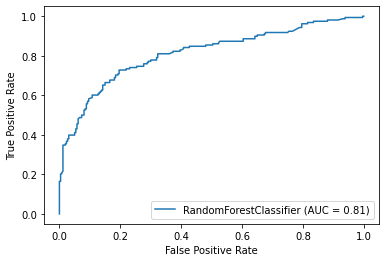

In [88]:
plot_roc_curve(rfc, test_df, test_surv)  
plt.show()

<Figure size 432x288 with 0 Axes>

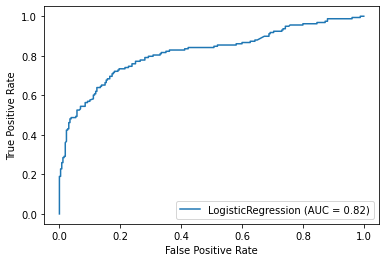

In [89]:
plt.clf()
plot_roc_curve(lr, test_df, test_surv)  
plt.show()

<Figure size 432x288 with 0 Axes>

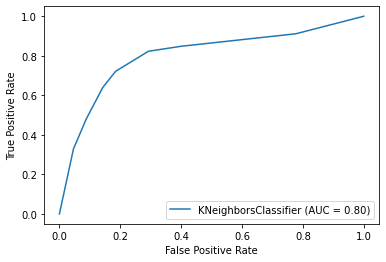

In [90]:
plt.clf()
plot_roc_curve(knn, test_sc, test_surv)  
plt.show()

<Figure size 432x288 with 0 Axes>

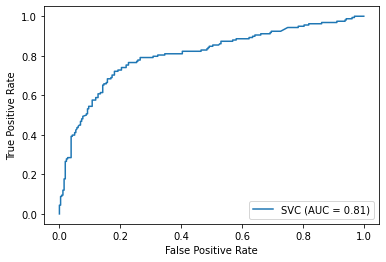

In [91]:
plt.clf()
plot_roc_curve(svc, test_sc, test_surv)  
plt.show()

The 4 plots above show the receiver operating characteristic (ROC) curve for each model. The ROC curve shows the trade off between sensitivity and specificity. True positive rate is along the y axis and false positive rate is along the x axis. The ideal model would be a curve which reaches the top left with a true positive rate of 1 and false positive rate of 0.

AUC is the area under the ROC curve. This provides an aggregate measure of performance for each class and is used as a summary for the ROC curve. The model with the best AUC is the RFC and the SVC with scores of 81. KNN had a score of 80 and LR had the lowest score of 68.